In [2]:
! pip install opencv-python

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
import cv2 

In [5]:
clean_labels = pd.read_csv("../data/clean_labels.csv", header = None)
noisy_labels = pd.read_csv("../data/noisy_labels.csv", header = None)

In [71]:
print(clean_labels.value_counts()) #clean data is fairly balanced

3    5101
4    5090
1    5070
5    5049
6    5033
8    5022
9    4938
7    4921
2    4920
0    4856
dtype: int64


In [7]:
n_img = 50000
all_imgs = np.empty((n_img, 32, 32, 3))

for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    all_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [8]:
clean_imgs = all_imgs[:10000,:,:,:] #images with human-verified labels
noisy_imgs = all_imgs[10000:,:,:,:] #images with just noisy labels

In [151]:
(clean_labels == noisy_labels.iloc[:10000]).sum() #number of correct labels in first 10000

0    3968
dtype: int64

what each label is:

1-car
2-bird
3-cat
4-deer
5-dog
6-frog
7-horse
8-ship
9-truck

In [152]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Concatenate, Add, Input, Embedding, Softmax
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD

In [153]:
np.random.seed(20)
tf.random.set_seed(20)

In [154]:
# one hot label data
clean_labs = to_categorical(clean_labels,num_classes = 10)
noisy_labs = to_categorical(noisy_labels,num_classes = 10)

In [155]:
# cleaning model construction
input_labels = Input(shape = (10,))
xl = Dense(128)(input_labels)

input_images = Input(shape = (32,32,3,))
xi = Conv2D(32,(3,3),1,padding="valid",activation = "relu")(input_images)
# xi = BatchNormalization()(xi)
xi = LeakyReLU(0.1)(xi)
xi = MaxPooling2D((2,2),padding="valid")(xi)
xi = Dropout(0.2)(xi)
xi = Conv2D(64,(3,3),1,padding="valid",activation = "relu")(xi)
# xi = BatchNormalization()(xi)
xi = LeakyReLU(0.1)(xi)
xi = MaxPooling2D((2,2),padding="valid")(xi)
xi = Dropout(0.2)(xi)
xi = Flatten()(xi)
xi = Dense(128, activation = "linear")(xi)

x = Concatenate()([xl,xi])
x = Dense(64, activation = "relu")(x)
x = Dropout(0.2)(x)
y = Dense(10, activation = "softmax")(x)
# y = Add()([input_labels,y]) #skip-connection to mitigate overfitting

model = Model(inputs = [input_labels,input_images], outputs = y, name = "label_cleaner")

In [157]:
opt = SGD(learning_rate=0.01)
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")

In [171]:
model.summary()

Model: "label_cleaner"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 30, 30, 32)   896         ['input_22[0][0]']               
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 30, 30, 32)   0           ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 15, 15, 32)  0           ['leaky_re_lu_18[0][0]']         
 )                                                                                    

In [158]:
#8:1:1 split
train_split = np.random.choice(10000,size = 8000,replace = False)
valid_split = np.random.choice(np.delete(np.arange(10000),train_split),size = 1000,replace = False)
test_split = np.delete(np.arange(10000),np.append(valid_split,train_split))

In [159]:
train1_imgs = clean_imgs[train_split,]/255.0
valid1_imgs = clean_imgs[valid_split,]/255.0
test1_imgs = clean_imgs[test_split,]/255.0

train1_labels = noisy_labs[train_split,]
ytrain1_labels = clean_labs[train_split,]
valid1_labels = noisy_labs[valid_split,]
yvalid1_labels = clean_labs[valid_split,]
test1_labels = noisy_labs[test_split,]
ytest1_labels = clean_labs[test_split,]

In [160]:
start = time.time()
cleaner_train = model.fit([train1_labels,train1_imgs], ytrain1_labels, epochs = 12, batch_size = 128, verbose=1, 
                          validation_data = ([valid1_labels,valid1_imgs],yvalid1_labels))
end = time.time()
print("Training took " + str((end-start)/60) + " minutes")

Epoch 1/12
63/63 [==============================] - 9s 129ms/step - loss: 2.0123 - accuracy: 0.3024 - val_loss: 1.7020 - val_accuracy: 0.4140
Epoch 2/12
63/63 [==============================] - 8s 124ms/step - loss: 1.5634 - accuracy: 0.4723 - val_loss: 1.4109 - val_accuracy: 0.5040
Epoch 3/12
63/63 [==============================] - 7s 105ms/step - loss: 1.3822 - accuracy: 0.5307 - val_loss: 1.3187 - val_accuracy: 0.5260
Epoch 4/12
63/63 [==============================] - 7s 110ms/step - loss: 1.2836 - accuracy: 0.5574 - val_loss: 1.2468 - val_accuracy: 0.5410
Epoch 5/12
63/63 [==============================] - 6s 102ms/step - loss: 1.1979 - accuracy: 0.5845 - val_loss: 1.1746 - val_accuracy: 0.5780
Epoch 6/12
63/63 [==============================] - 7s 106ms/step - loss: 1.1258 - accuracy: 0.6139 - val_loss: 1.1955 - val_accuracy: 0.5880
Epoch 7/12
63/63 [==============================] - 6s 103ms/step - loss: 1.0961 - accuracy: 0.6219 - val_loss: 1.1397 - val_accuracy: 0.5930
Epoch 

In [161]:
hist = cleaner_train.history
hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

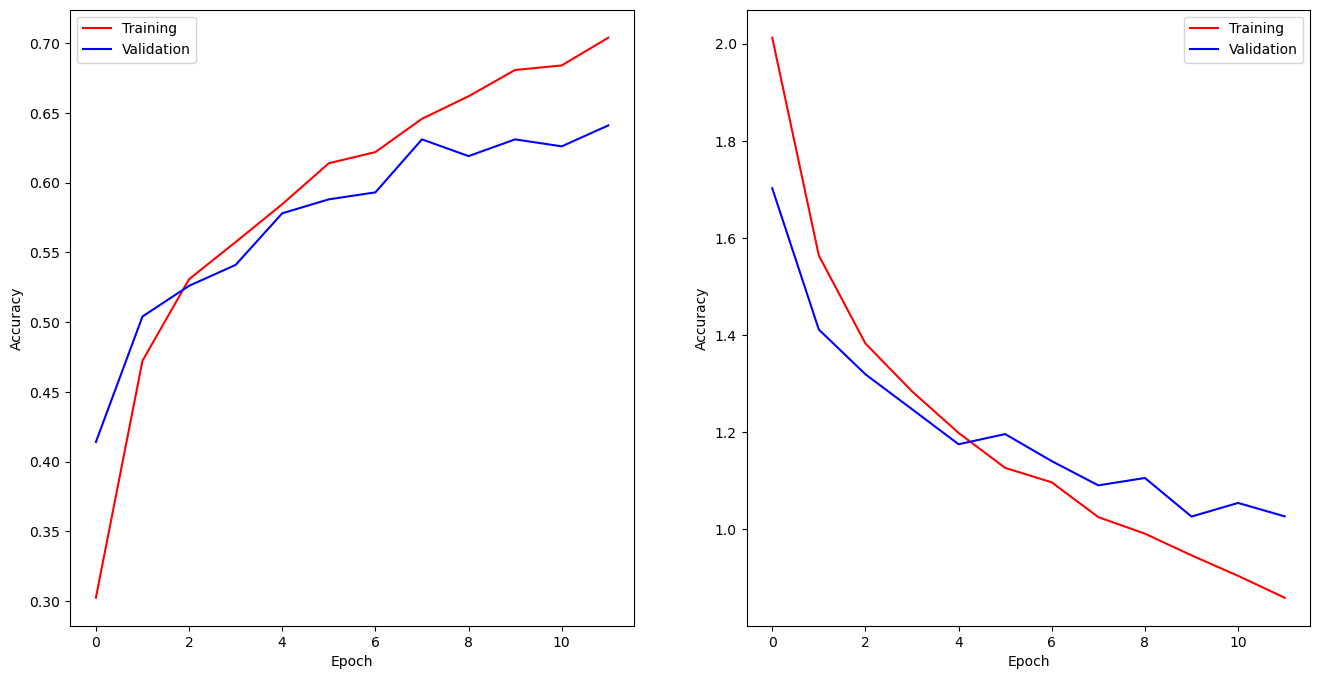

In [162]:
fix, ax = plt.subplots(figsize = (16,8), nrows = 1, ncols = 2)

ax[0].plot(hist["accuracy"], "r", label = "Training")
ax[0].plot(hist["val_accuracy"], "b", label = "Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(hist["loss"], "r", label = "Training")
ax[1].plot(hist["val_loss"], "b", label = "Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [19]:
# def model_abs_loss(noisy,imgs,true): 
#     output = model.predict([noisy,imgs])
#     loss = 0
#     for i in range(len(noisy)):
#         loss += abs(np.argmax(output[i])-np.argmax(true[i])) #choose label with highest value
#     return loss

In [163]:
test_loss, test_accuracy = model.evaluate([test1_labels,test1_imgs], ytest1_labels)
# model_abs_loss(test1_labels,test1_imgs, ytest1_labels)

32/32 [==============================] - 0s 14ms/step - loss: 0.9869 - accuracy: 0.6590


In [164]:
start = time.time()
predicted_prob = model.predict([noisy_labs,all_imgs])
predicted_labels = np.argmax(predicted_prob, axis = 1)
end = time.time()
print("Generating labels took " + str((end-start)/60) + " minutes")

1563/1563 [==============================] - 14s 9ms/step
Generating labels took 0.31249671379725136 minutes


In [165]:
predicted_labels[:40] #looks a little sus

array([5, 9, 9, 5, 1, 1, 7, 7, 8, 7, 5, 7, 7, 1, 9, 0, 9, 5, 7, 6, 0, 1,
       6, 7, 9, 9, 5, 1, 7, 0, 1, 9, 1, 5, 4, 7, 8, 7, 0, 0])

In [127]:
predicted_labels.shape

(50000,)

In [170]:
label_count = []
for i in range(9):
    label_count.append(np.count_nonzero(predicted_labels==i))
print(label_count)

[6685, 8177, 822, 1172, 470, 8604, 2729, 10223, 4846]
